# 1) Image Preprocessing

In [1]:
#final variables containing number_of_classes & size of resized_image
N_CLASSES = 43
RESIZED_IMAGE = (32, 32)

In [2]:
# function that:
#   reads all images given in a path
#   resize them to a predefined shape
#   convert then to GRAYSCALE
#   one-hot encode the label    

In [3]:
import matplotlib.pyplot as plt
import glob
from skimage.color import rgb2lab
from skimage.transform import resize
from collections import namedtuple
import numpy as np

np.random.seed(101)

%matplotlib inline

Dataset = namedtuple('Dataset', ['X', 'y'])
def to_tf_format(imgs):
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis=0).astype(np.float32)

def read_dataset_ppm(rootpath, n_labels, resize_to):
    images = []
    labels = []
    for c in range(n_labels):
        full_path = rootpath + '/' + format(c, '05d') + '/'
        for img_name in glob.glob(full_path + "*.ppm"):
            img = plt.imread(img_name).astype(np.float32)
            img = rgb2lab(img / 255.0)[:, :, 0]
            if resize_to:
                img = resize(img, resize_to, mode='reflect')
            label = np.zeros((n_labels, ), dtype=np.float32)
            label[c] = 1.0
            images.append(img.astype(np.float32))
            labels.append(label)
    return Dataset(X = to_tf_format(images).astype(np.float32),
                  y = np.matrix(labels).astype(np.float32))

dataset = read_dataset_ppm('GTSRB/FInal_Training/Images', N_CLASSES, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

(39209, 32, 32, 1)
(39209, 43)


In [6]:
# Skimage Module : reading, transforming, & resizing Image
# Convert original color space(RGB) to lab, then retaining only the LUMINANCE component
# in-case of conversion to YUV, only "Y" should be retained

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


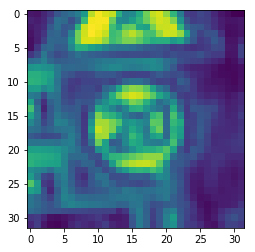

In [5]:
#printing feature vector of the first sample, together with its label

#sample
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE))
#label
print(dataset.y[0, :])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


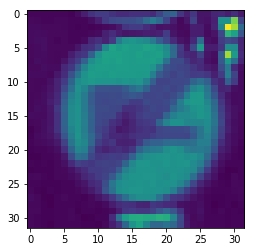

In [7]:
#printing feature vector of the last sample, together with its label

#sample
plt.imshow(dataset.X[-1, :, :, :].reshape(RESIZED_IMAGE))
#label
print(dataset.y[-1, :])

### train/test split

In [8]:
from sklearn.model_selection import train_test_split
# 75% of the samples in the dataset -> TRAINING
# 25% of the remaining samples -> TESTING
idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size=0.25, random_state=101)
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(29406, 32, 32, 1)
(29406, 43)
(9803, 32, 32, 1)
(9803, 43)


# 2) Train Model & make Predictions

In [9]:
# function to create mini-batches of training data
def minibatcher(X, y, batch_size, shuffle):
    assert X.shape[0] == y.shape[0]
    n_samples = X.shape[0]
    if shuffle:
        idx = np.random.permutation(n_samples)
    else:
        idx = list(range(n_samples))
    for k in range(int(np.ceil(n_samples/batch_size))):
        from_idx = k*batch_size
        to_idx = (k+1)*batch_size
        yield X[idx[from_idx:to_idx], :, :,], y[idx[from_idx:to_idx], :]

In [10]:
# printing shape of minibatch, while imposing batch_size=10000
for mb in minibatcher(X_train, y_train, 10000, True):
    print(mb[0].shape, mb[1].shape)

(10000, 32, 32, 1) (10000, 43)
(10000, 32, 32, 1) (10000, 43)
(9406, 32, 32, 1) (9406, 43)


### Building the Model

* 1) Creating fully connected layer with variable number of units, without activation
* 2) Xavier initialization for coefficients(weights);
* 3) o-initialization for biases to have the layer centered & scaled properly
* 4) output -> multiplication of input tensor, plus the bias

In [11]:
import tensorflow as tf

def fc_no_activation_layer(in_tensors, n_units):
    w = tf.get_variable('fc_W', 
                        [in_tensors.get_shape()[1], n_units],
                        tf.float32,
                        tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('fc_B',
                        [n_units, ],
                        tf.float32,
                        tf.constant_initializer(0.0))
    return tf.matmul(in_tensors, w) + b

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1) Creating fully connected layer with activation; using leaky ReLU

In [12]:
def fc_layer(in_tensors, n_units):
    return tf.nn.leaky_relu(fc_no_activation_layer(in_tensors, n_units))

1) Creating convolutional layer, with arguments : imput data, kernel size, number of filters(or units)

In [13]:
def conv_layer(in_tensors, kernel_size, n_units):
    w = tf.get_variable('conv_W',
                       [kernel_size, kernel_size, in_tensors.get_shape()[3], n_units],
                       tf.float32,
                       tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('conv_B',
                       [n_units, ],
                       tf.float32,
                       tf.constant_initializer(0.0))
    return tf.nn.leaky_relu(tf.nn.conv2d(in_tensors, w, [1,1,1,1], 'SAME') + b)

1) Creating maxpool_layer
2) size of window & strides are both squares(Quadrates)

In [14]:
def maxpool_layer(in_tensors, sampling):
    return tf.nn.max_pool(in_tensors, [1, sampling, sampling, 1],
                         [1, sampling, sampling, 1], 'SAME')

* 1) Defining DROPOUT, for regularizing the network
* 2) DROPOUT is used only when training the network, not when predicting

In [15]:
def dropout(in_tensors, keep_proba, is_training):
    return tf.cond(is_training, lambda: tf.nn.dropout(in_tensors, keep_proba),
                  lambda: in_tensors)

Creating a model composed of following layers:
* 1) 2D convolution, 5X5, 32 filters
* 2) 2D convolution, 5X5, 64 filters
* 3) Flattenizer
* 4) Fully connected layer, 1024 units
* 5) Dropout 40%
* 6) Fully Connected layer, no activation
* 7) Softmax output

In [16]:
def  model(in_tensors, is_training):
    #First layer : 5x5 2d-conv, 32 filters, 2x maxpool, 20% dropout
    with tf.variable_scope('l1'):
        l1 = maxpool_layer(conv_layer(in_tensors, 5, 32), 2)
        l1_out = dropout(l1, 0.8, is_training)
    #Second layer : 5x5 2d-conv, 64 filters, 2x maxpool, 20% dropout
    with tf.variable_scope('l2'):
        l2 = maxpool_layer(conv_layer(l1_out, 5, 64), 2)
        l2_out = dropout(l2, 0.8, is_training)
    
    with tf.variable_scope('flatten'):
        l2_out_flat = tf.layers.flatten(l2_out)
  
    #Fully collected layer, 1024 neurons, 40% dropout 
    with tf.variable_scope('l3'):
        l3 = fc_layer(l2_out_flat, 1024)
        l3_out = dropout(l3, 0.6, is_training)
  
    # Output
    with tf.variable_scope('out'):
        out_tensors = fc_no_activation_layer(l3_out, N_CLASSES)
  
    return out_tensors

Epoch= 0
 train_loss_score= 4.391157
Epoch= 1
 train_loss_score= 0.7811591
Epoch= 2
 train_loss_score= 0.37790203
Epoch= 3
 train_loss_score= 0.23970334
Epoch= 4
 train_loss_score= 0.16011767
Epoch= 5
 train_loss_score= 0.13303156
Epoch= 6
 train_loss_score= 0.0970355
Epoch= 7
 train_loss_score= 0.08074143
Epoch= 8
 train_loss_score= 0.0687234
Epoch= 9
 train_loss_score= 0.06179753
TEST SET PERFORMANCE
 test_loss_score= 0.06605987
             precision    recall  f1-score   support

          0       1.00      0.88      0.94        67
          1       0.95      0.99      0.97       539
          2       0.98      0.99      0.99       558
          3       1.00      0.96      0.98       364
          4       0.99      0.99      0.99       487
          5       0.98      0.97      0.98       479
          6       1.00      1.00      1.00       105
          7       0.99      0.97      0.98       364
          8       0.96      0.99      0.98       340
          9       0.98      1.00  

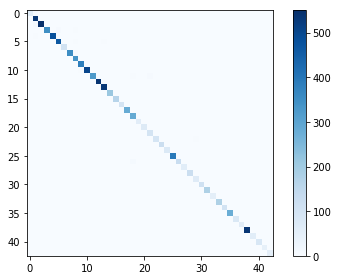

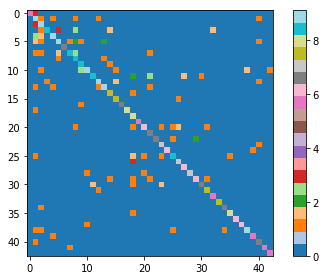

In [19]:
from sklearn.metrics import classification_report, confusion_matrix


def train_model(X_train, y_train, X_test, y_test, learning_rate, max_epochs, batch_size):
    in_X_tensors_batch = tf.placeholder(tf.float32, shape = (None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1))
    in_y_tensors_batch = tf.placeholder(tf.float32, shape = (None, N_CLASSES))
    is_training = tf.placeholder(tf.bool)

    logits = model(in_X_tensors_batch, is_training)
    out_y_pred = tf.nn.softmax(logits)
    loss_score = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=in_y_tensors_batch)
    loss = tf.reduce_mean(loss_score)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    with tf.Session() as session:
        session.run(tf.global_variables_initializer())

        for epoch in range(max_epochs):
            print("Epoch=", epoch)
            tf_score = []

            for mb in minibatcher(X_train, y_train, batch_size, shuffle = True):
                tf_output = session.run([optimizer, loss], 
                                        feed_dict = {in_X_tensors_batch : mb[0], 
                                                     in_y_tensors_batch : mb[1], is_training : True})

                tf_score.append(tf_output[1])
            print(" train_loss_score=", np.mean(tf_score))
        
        # after the training is done, time to test it on the test set
        print("TEST SET PERFORMANCE")
        y_test_pred, test_loss  = session.run([out_y_pred, loss], 
                                              feed_dict = {in_X_tensors_batch : X_test, 
                                                           in_y_tensors_batch : y_test,
                                                           is_training : False})

        print(" test_loss_score=", test_loss)
        y_test_pred_classified = np.argmax(y_test_pred, axis=1).astype(np.int32)
        y_test_true_classified = np.argmax(y_test, axis=1).astype(np.int32)
        print(classification_report(y_test_true_classified, y_test_pred_classified))

        cm = confusion_matrix(y_test_true_classified, y_test_pred_classified)

        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        plt.tight_layout()
        plt.show()

        # And the log2 version, to enphasize the misclassifications
        plt.imshow(np.log2(cm + 1), interpolation='nearest', cmap=plt.get_cmap("tab20"))
        plt.colorbar()
        plt.tight_layout()
        plt.show()


tf.reset_default_graph()
train_model(X_train, y_train, X_test, y_test, 0.001, 10, 256)
